Imports

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2


Data Processing

In [2]:
filelist = []

import os
for dirname, _, filenames in os.walk(r"C:\Users\arthu\Desktop\dataset"):
    for filename in filenames:        
        filelist.append(os.path.join(dirname, filename))

In [3]:
labels = []
images = []
for image_path in filelist:
    # Lê a imagem em escala de cinza usando OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255  # Normalização
    
    # Redimensiona a imagem para as dimensões desejadas
    resized_image = cv2.resize(image, (150, 40))
    
    # Adiciona a dimensão do canal
    reshaped_image = np.expand_dims(resized_image, axis=-1)
    
    images.append(reshaped_image)
    
    image_label = image_path.split("\\")[-1].split(".")[0]
    labels.append(image_label)

# Convertendo as listas para arrays numpy
images = np.array(images)
labels = np.array(labels)

In [4]:
images = np.stack(images)
print(images.shape)

(73062, 40, 150, 1)


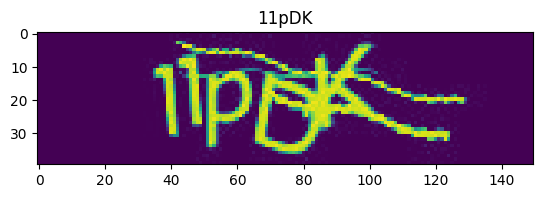

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [5]:
plt.imshow(images[19])
plt.title(labels[19])
plt.axis('on')  # Turn off axis labels
plt.show()

print(images[19])

In [6]:
#One-Hot Encoding List of 5 character strings
def one_hot_encode(characters, char_pool):
    char_to_index = {char: i for i, char in enumerate(char_pool)}
    num_classes = len(char_pool)
    encoding_size = len(characters[0])
    
    one_hot_encoded = np.zeros((len(characters), encoding_size, num_classes), dtype=int)

    for i, word in enumerate(characters):
        for j, char in enumerate(word):
            index = char_to_index[char]
            one_hot_encoded[i, j, index] = 1

    return one_hot_encoded

# Character pool: digits 0-9 and lowercase letters a-z
char_pool = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# List of 5-letter strings
strings_list = ["abdy6", "ajyt8"]

# One-hot encode the list
one_hot_encoded = one_hot_encode(strings_list, char_pool)

# Print the one-hot encoded representation
print("One-Hot Encoded:")
print(one_hot_encoded)

One-Hot Encoded:
[[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [7]:
#Encoding Labels
encoded_labels = one_hot_encode(labels, char_pool)
encoded_labels = np.array(encoded_labels)
encoded_labels.shape, encoded_labels

((73062, 5, 62),
 array([[[0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 1, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 1, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
 

In [8]:
#Shuffling Array
indices = np.random.permutation(len(labels))

images = images[indices]
encoded_labels = encoded_labels[indices]

images.shape, encoded_labels.shape

((73062, 40, 150, 1), (73062, 5, 62))

In [9]:
#Train-Validation Split
split_index = int(len(labels) * 0.9)

train_labels = encoded_labels[:split_index]
val_labels = encoded_labels[split_index:]

train_images = images[:split_index]
val_images = images[split_index:]

Creating Model

In [10]:
# Convolutional Layer
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 150, 1)))  # Ajuste de input_shape para escala de cinza
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 148, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 36, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 34, 64)         36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 

In [12]:
#Dense Layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5 * 62, activation='softmax'))
model.add(layers.Reshape((5, 62)))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 148, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 36, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 34, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 13056)             0

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Training

In [15]:
history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(val_images, val_labels))

Epoch 1/100
2055/2055 [==============================] - 159s 77ms/step - loss: 3.8097 - accuracy: 0.0568 - val_loss: 3.3092 - val_accuracy: 0.1312
Epoch 2/100
2055/2055 [==============================] - 157s 77ms/step - loss: 3.0619 - accuracy: 0.1663 - val_loss: 2.8864 - val_accuracy: 0.1937
Epoch 3/100
2055/2055 [==============================] - 158s 77ms/step - loss: 2.7414 - accuracy: 0.2210 - val_loss: 2.6891 - val_accuracy: 0.2305
Epoch 4/100
2055/2055 [==============================] - 158s 77ms/step - loss: 2.5712 - accuracy: 0.2538 - val_loss: 2.6193 - val_accuracy: 0.2492
Epoch 5/100
2055/2055 [==============================] - 157s 77ms/step - loss: 2.4585 - accuracy: 0.2784 - val_loss: 2.5725 - val_accuracy: 0.2587
Epoch 6/100
2055/2055 [==============================] - 157s 76ms/step - loss: 2.3729 - accuracy: 0.2963 - val_loss: 2.5017 - val_accuracy: 0.2748
Epoch 7/100
2055/2055 [==============================] - 157s 76ms/step - loss: 2.3039 - accuracy: 0.3114 - val_

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()